# Autoencoder for image compression using Deep learning

In [56]:
# install python libraties requires to run the code in your workspace
# !pip install -r requirements.txt

In [57]:
#importing librarys

# cv2 is a python extarnal package to do image processing and manipulation related stuff.
import cv2 

# imutils is a series of convenience functions to make basic image processing easy.
import imutils

# tensorflow is a python library for machine learning and artificial intelligence related work.
import tensorflow as tf 


# NumPy is a Python library used for working with arrays
import numpy as np



# Keras is a library that provides a Python interface for artificial neural networks. 
# Keras acts as an interface for the TensorFlow library.
import keras


# 1. Keras layers are the building blocks of the Keras library that can be stacked together for creating neural network models.
# 2. Keras Conv2D creates a 2D convolution kernel that is wind with layers input which helps produce a tensor of outputs.
# 3. maxpooling2D Downsamples the input along its spatial dimensions by taking the maximum value over an input window for each channel of the input. 
# 4 .Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
# 5 .Dropout regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data.
# 6. Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


#  Model groups layers into an object with training and inference features.
from tensorflow.keras.models import Model

# tensorflow.keras.callbacks is used to visualize training of a model.
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint 

# used to split dataset(features and target) into test and test
from sklearn.model_selection import train_test_split

# F1/F Score is a measure of how accurate a model is by using Precision and Recall following the 
# formula of: F1_Score = 2 * ((Precision * Recall) / (Precision + Recall)) 
# Precision is commonly called positive predictive value.
from sklearn.metrics import f1_score

# shuffle the dataset for a even mixture of each type of feature and target.it gives better result.
from sklearn.utils import shuffle

# A one hot encoding allows the representation of categorical data to be more expressive.
from sklearn.preprocessing import OneHotEncoder

# confusion matrix is used to evaluate the accuracy of a classification.[[TP,FP],[FN,TN]]
# A classification report is a performance evaluation metric in machine learning. 
# It is used to show the precision, recall, F1 Score, and support of your trained classification model.
from sklearn.metrics import confusion_matrix,classification_report

# The OS module in Python provides functions for interacting with the operating system.
import os

# Matplotlib is a data visualization and graphical plotting library for Python.
import matplotlib.pyplot as plt

# seaborn is alse a data visualization and graphical plotting library for Python.
import seaborn as sn

# used to display markdown,image,control (frontend utilities)
from IPython import display

# to subpress warning
import warnings
warnings.filterwarnings("ignore")


# dataset path 
path = "D:/Image_datasets/brain_tumor_dataset"
# make sure in this dir two folder named "yes" and "no" is present. 

In [58]:
# GPU Info 
try:
    import GPUtil
except:
    !pip install GPUtil
    import GPUtil

    
# check physical computing devices
device=tf.config.experimental.list_physical_devices()
for i in device:
    print(i)
if len(device)>1:
    # find GPU details
    print("="*20, "GPU Details", "="*20)
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(gpu_id,gpu.name, gpu.driver,gpu.memoryTotal,gpu.temperature)



PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [59]:
# this function crop out the unnecessary part of a image.
# it takes two parameter -> image : numpy/cv2 image array , plot : binary (You want to plot after before effect of the image)


def image_threshholder(image, plot=False):
    
    # binary threshholding the image to clean the gray scale range and makes the image binary colored based on range.
#     to remove thresh holding comment the next line
    new_image= cv2.threshold(image, 100, 255, cv2.THRESH_BINARY,cv2.CHAIN_APPROX_SIMPLE)[1]
    if plot:
        # plots the after before effect on the image based on parameter plot
        # plot if plot=true, ignore the if block if plot=False
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("original image")
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("processed image")
        plt.show()
        
    return new_image

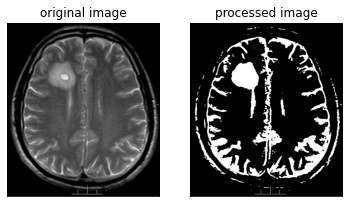

In [60]:
# testing the crop_contour_brain_img() function
example_image=cv2.imread(path+"/yes/Y3.jpg")
img=image_threshholder(example_image,True)
# plt.imshow(img)
print()

In [61]:
# view directory tree
def tree_printer(root):
    try:
        if ":" not in root:
            root=os.getcwd().replace("\\","/")+root
            print(root)
        if not os.path.isdir(root) and root!="":
            print(root,": path not exists....")
            return
    except:
        print("🛠️ set path of the data set from your local mechine")
        return
    
    
    print("🗁",root)
    for name in os.listdir(root):
        try:
            print(" |- 🗁",name," "*2+"🏴",len(os.listdir(os.path.join(root, name))),"items")
        except:
            continue
            
tree_printer(path)

🗁 D:/Image_datasets/brain_tumor_dataset
 |- 🗁 no   🏴 98 items
 |- 🗁 yes   🏴 155 items


In [62]:
image_size=(28,28) # defining the image size 
hotencoder = OneHotEncoder() # calling the OneHotEncoder
hotencoder.fit([[0], [1]]) # using binary crossentropy over catagorical crossentropy


# load the images from the local mechine and process before putting the resultent list.
def load_images(path,type=["jpg","jpeg"],target=0,images=[],orgimages=[],result=[]):
    for filepath in os.listdir(path):
        if filepath.split(".")[-1].lower() in type:
            img=cv2.imread(path+"/"+filepath)
            # filtering the image
            img=image_threshholder(img)
            # resizing the image in defined size
            img=cv2.resize(img,image_size)
            # convert the image to gray
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # 3d image to 2D
            img = np.expand_dims(img, 2)
            # 2D to 1D convertion
            img=img.reshape(-1)
            # returning to 2d image
            orgimg=np.reshape(img,image_size)
            # putting in image array
            img=np.array(img)
            # inserting flatten image to list
            images.append(img)
            # inserting 2D image to list
            orgimages.append(orgimg)
            # appening the terget 0 for tumor,1 for no tumor
            result.append(target)
            
    return [images,orgimages,result]

# plot images 
def show_image(datasets,num=4):  
    for i in range(num**2):
        plt.subplot(num, num, i+1)
        plt.imshow(datasets[i])
        plt.axis('off')


In [63]:
# load the image having brain cancer
images,orgimages,result=load_images(path+"/yes",target=0,images=[],orgimages=[],result=[])
# print(images.shape)
# show_image(images)
# print(result)


In [64]:
# loading the images not having brain cancer
images,orgimages,result=load_images(path+"/no",target=1,images=images,orgimages=orgimages,result=result)
# print(no_images.shape)
# show_image(images)
print("total images :",len(result),"| total targets :",len(images))

total images : 251 | total targets : 251


# validation of data,original data and target

In [65]:
# image dataset is stored in variable data
data=np.array(images)
print(data.shape)
data=data/255

(251, 784)


In [66]:
# unnecessary part for this project
orgdata=np.array(orgimages)
print(orgdata.shape)

(251, 28, 28)


In [67]:
target=np.array(result)
print(target.shape)

(251,)


## spliting of data,orgdata,target

In [68]:
# customized test train splitter
def test_train_splitter(data,ratio=0.2):
    range=int(data.shape[0]*(1-0.2))
    x_train=data[:range]
    x_test=data[range:]
    return x_train,x_test

x_train,x_test=test_train_splitter(data)
print(x_train.shape,x_test.shape)

(200, 784) (51, 784)


# model starts here -----------:)

In [69]:
# importing necessary packages
# view explanation in 2nd cell
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets

## encoder model

In [70]:
# encoder model func
# encode the image in 64bit image(8X8)
def get_encoder():
    # Encoder input shape (784,)
    x = tensorflow.keras.layers.Input(shape=(784), name="encoder_input")

    # neurons in a Dense layer is now 300 
    encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_1")(x)
    encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

    # neurons in a Dense layer is decreased to 64
    encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_2")(encoder_activ_layer1)
    encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

    # containerized the model
    encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
    return encoder

encoder=get_encoder()
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder_dense_1 (Dense)     (None, 300)               235500    
                                                                 
 encoder_leakyrelu_1 (LeakyR  (None, 300)              0         
 eLU)                                                            
                                                                 
 encoder_dense_2 (Dense)     (None, 64)                19264     
                                                                 
 encoder_output (LeakyReLU)  (None, 64)                0         
                                                                 
Total params: 254,764
Trainable params: 254,764
Non-trainable params: 0
_______________________________________________

## decoder model

In [71]:
# decoder model func
# encode the encoded image(64bit) back to original size(784 bit).
def get_decoder():
    decoder_input = tensorflow.keras.layers.Input(shape=(64), name="decoder_input")

    # neurons in a Dense layer is now 300 
    decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input)
    decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

    # neurons in a Dense layer is increased to 300.
    decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=784, name="decoder_dense_2")(decoder_activ_layer1)
    decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)
    # containerized the model
    decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
    return decoder

decoder=get_decoder()
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 64)]              0         
                                                                 
 decoder_dense_1 (Dense)     (None, 300)               19500     
                                                                 
 decoder_leakyrelu_1 (LeakyR  (None, 300)              0         
 eLU)                                                            
                                                                 
 decoder_dense_2 (Dense)     (None, 784)               235984    
                                                                 
 decoder_output (LeakyReLU)  (None, 784)               0         
                                                                 
Total params: 255,484
Trainable params: 255,484
Non-trainable params: 0
_______________________________________________

## autoencoder model

In [72]:
# Autoencoder model
# combine and sync the encoder and decoder model.
# parameter encoder model and decoder model.

def autoencoder(encoder,decoder):
    ae_input = tensorflow.keras.layers.Input(shape=(784), name="AE_input")
    # encoding the input images
    ae_encoder_output = encoder(ae_input)
    # decoding the encoded image back to original shape
    ae_decoder_output = decoder(ae_encoder_output)

    ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
    return ae


ae=autoencoder(encoder,decoder)
ae.summary()

    



Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder_model (Functional)  (None, 64)                254764    
                                                                 
 decoder_model (Functional)  (None, 784)               255484    
                                                                 
Total params: 510,248
Trainable params: 510,248
Non-trainable params: 0
_________________________________________________________________


In [73]:
# calculating RMSE of autoencoder
# RMSE is a measure of how spread out these residuals are. 
# It tells you how concentrated the data is around the line of best fit. 
def rmse(y_true, y_predict):
    return tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))

# AE Compilation
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005))



In [74]:
# preparing brain tumor dataset spliting into test train default ratio is 0.2

x_train,x_test=test_train_splitter(data)
print(x_train.shape,x_test.shape)

x_train_org,x_test_org=test_train_splitter(orgdata)
print(x_train_org.shape,x_test_org.shape)

y_train,y_test=test_train_splitter(target)
print(y_train.shape,y_test.shape)



(200, 784) (51, 784)
(200, 28, 28) (51, 28, 28)
(200,) (51,)


In [75]:
# # Preparing MNIST Dataset
# (x_train_orig, y_train), (x_test_orig, y_test) = tensorflow.keras.datasets.mnist.load_data()
# x_train_orig = x_train_orig.astype("float32") / 255.0
# x_test_orig = x_test_orig.astype("float32") / 255.0

# x_train = numpy.reshape(x_train_orig, newshape=(x_train_orig.shape[0], numpy.prod(x_train_orig.shape[1:])))
# x_test = numpy.reshape(x_test_orig, newshape=(x_test_orig.shape[0], numpy.prod(x_test_orig.shape[1:])))
# # x_test_orig.shape,x_test.shape,y_test.shape
# y_test[0]

In [76]:
# Training Autoencoder
ae.fit(x_train, x_train, epochs=20, batch_size=10, shuffle=True, validation_data=(x_test, x_test))

encoded_images = encoder.predict(x_train)
decoded_images = decoder.predict(encoded_images)

# reshaping the image of (784,) to plotable image(28,28)
decoded_images_orig = np.reshape(decoded_images, newshape=(decoded_images.shape[0], 28, 28))


Epoch 1/20
20/20 [==============================] - 4s 77ms/step - loss: 0.1691 - val_loss: 0.1067
Epoch 2/20
20/20 [==============================] - 1s 30ms/step - loss: 0.1216 - val_loss: 0.1009
Epoch 3/20
20/20 [==============================] - 1s 30ms/step - loss: 0.1126 - val_loss: 0.0967
Epoch 4/20
20/20 [==============================] - 1s 27ms/step - loss: 0.1043 - val_loss: 0.0930
Epoch 5/20
20/20 [==============================] - 1s 33ms/step - loss: 0.0965 - val_loss: 0.0907
Epoch 6/20
20/20 [==============================] - 1s 37ms/step - loss: 0.0895 - val_loss: 0.0885
Epoch 7/20
20/20 [==============================] - 1s 31ms/step - loss: 0.0830 - val_loss: 0.0876
Epoch 8/20
20/20 [==============================] - 1s 38ms/step - loss: 0.0782 - val_loss: 0.0860
Epoch 9/20
20/20 [==============================] - 1s 40ms/step - loss: 0.0739 - val_loss: 0.0871
Epoch 10/20
20/20 [==============================] - 1s 34ms/step - loss: 0.0697 - val_loss: 0.0840
Epoch 11/

# Analyzing compression ratio

encoder image shape (64,)
decoder image shape (784,)
compression ratio : 0.08163265306122448
compression percentage : 8.16 %
compression loss percentage : 91.84 %


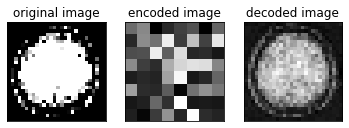

In [77]:
print("encoder image shape",encoded_images[0].shape)
print("decoder image shape",decoded_images[0].shape)

# compression_ratio=encoded_image_size / decoded_images or original images size
# as we have input of images of size (784,) and encoder output is(64,)

compression_ratio=encoded_images[0].shape[0] / decoded_images[0].shape[0]
print("compression ratio :", compression_ratio)

# compression percentage is compression ratio * 100
print("compression percentage :",round(compression_ratio*100,2),"%")

# loss at encoding is 100 - compression ratio * 100
print("compression loss percentage :",round(100 - (compression_ratio*100),2),"%")


# ploting the comparition between original,encoded and decoded image.

plt.figure()
plt.subplot(1,3,1)
original_sample=orgdata[0]
plt.imshow(original_sample,cmap="gray")
plt.tick_params(axis="both", which="both",
                top=False,bottom=False,left=False,right=False,
                labelbottom=False,labeltop=False,labelleft=False,
                labelright=False)
plt.title("original image")
        
plt.subplot(1,3,2)
encoded_sample = np.reshape(encoded_images, newshape=(decoded_images.shape[0], 8, 8))[0]
plt.imshow(encoded_sample,cmap="gray")
plt.tick_params(axis="both", which="both",
                top=False,bottom=False,left=False,right=False,
                labelbottom=False,labeltop=False,labelleft=False,
                labelright=False)
plt.title("encoded image")

plt.subplot(1,3,3)
decoded_sample=decoded_images_orig[0]
plt.imshow(decoded_sample,cmap="gray")
plt.tick_params(axis="both", which="both",
                top=False,bottom=False,left=False,right=False,
                labelbottom=False,labeltop=False,labelleft=False,
                labelright=False)
plt.title("decoded image")
plt.show()


In [78]:
64/784

0.08163265306122448

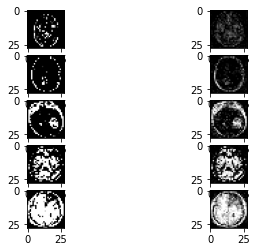

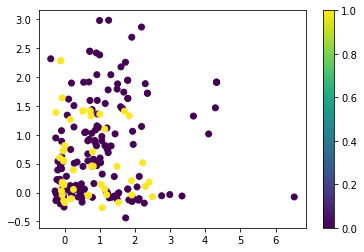

In [79]:
import warnings
warnings.filterwarnings("ignore")
# comparing some more images between original and decode image.
num_images_to_show = 5
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    plt.subplot(num_images_to_show, 2, plot_ind)
    plt.imshow(x_train_org[rand_ind, :, :], cmap="gray")
    plt.subplot(num_images_to_show, 2, plot_ind+1)
    
    # convert 2D image to 3D
    img_bgr = cv2.cvtColor(decoded_images_orig[rand_ind], cv2.COLOR_GRAY2BGR)
    # Clipping data to the valid range for imshow with RGB data ([0..1]
    plt.imshow(np.clip(img_bgr, 0, 1))

plt.figure()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=y_train)
plt.colorbar()

In [1]:
!jt -t oceans16 -T -N -kl

In [81]:
# !jt -l
# !jt -r

Reset css and font defaults in:
C:\Users\TIRTHA\.jupyter\custom &
C:\Users\TIRTHA\AppData\Roaming\jupyter\nbextensions
